## Markovian simulation 

- Last updated: 5/15/2024
- Author: Yang-Joon Kim

This notebook is to test out the ideas discussed with Guillaume Le Treut and Sarah Ancheta

- 





### inputs: 
- 1) adata with celltype annotations (adata.obs.global_annotation)
- 2) cell-cell transition probabilities
- 3) 

### outputs:

In [2]:
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import scanpy as sc

from scipy.sparse import csr_matrix
from scipy.linalg import expm
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import celloracle as co

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

In [3]:
%matplotlib inline

## cleaning up the code from here:
### for one timepoint

In [4]:
# import the oracle
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/TDR126/10_TDR126_pseudotime.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 15036
    n_genes: 3000
    cluster_name: global_annotation
    dimensional_reduction_name: X_umap.joint
    n_target_genes_in_TFdict: 13625 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 330 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1752 genes
    k_for_knn_imputation: 375
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [5]:
# extract the adata from the oracle object
adata = oracle.adata
adata

AnnData object with n_obs × n_vars = 15036 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.unassigned', 'prediction.score.Neural_Anterior', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.PSM', 'prediction.score.Neural_Posterior', 'prediction.score.Epidermal', 'prediction.score.Somites', 'prediction.score.NMPs', 'prediction.score.Endoderm', 'prediction.score.Muscle', 'prediction.score.Notochord', 'prediction.score.Differentiating_Neurons', 'prediction.score.Germline', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'Lineage_Meso', 'Lineage_NeuroEcto', 

In [11]:
goi="geneA"

len(goi)

5

In [13]:
# compute the transition probability for a given gene KO
goi = ""

# three cases: (1) WT (None), (2) one gene KO, (3) multiome gene KOs
# if goi==None:
#     perturb_condition = {}
# elif goi:
#     perturb_condition = {goi: 0.0}
# else:
#     perturb_condition = 

if goi=="":
    perturb_condition = {}
elif goi:
    perturb_condition = {goi: 0.0}
    


# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition=perturb_condition,
                      n_propagation=3)

# estimate the cell-cell transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [4]:
#computed in the CellOracle 'space' (conda environment)
def get_transition_matrix(oracle_object):
    matrix = oracle.transition_prob.copy()
    dense_array = np.array(matrix, dtype=np.float32)
    trans_probs = dense_array
    # Convert dense array to a sparse matrix
    # sparse_matrix = csr_matrix(dense_array)
    #     adata.uns['transition_matrix'] = sparse_matrix
    return trans_probs

# def get_transition_matrix(oracle_object):
#     matrix = oracle.transition_prob.copy()
#     dense_array = np.array(matrix, dtype=np.float32)
#     # Convert dense array to a sparse matrix
#     sparse_matrix = csr_matrix(dense_array)
# #     adata.uns['transition_matrix'] = sparse_matrix
#     return sparse_matrix
    
    # extract the cell_ids from adata
#     adata = oracle.adata
#     cell_ids = adata.obs_names
#     df_trans_probs = pd.DataFrame(dense_array, index=cell_ids, columns=cell_ids)
    
#     return df_trans_probs

In [153]:
# extract the transition probabilities as "sparse matrix" format
trans_probs_sparse = get_transition_matrix(oracle)
trans_probs_sparse

<15036x15036 sparse matrix of type '<class 'numpy.float32'>'
	with 3022236 stored elements in Compressed Sparse Row format>

In [154]:
adata.uns["trans_probs_WT"] = trans_probs_sparse
adata

AnnData object with n_obs × n_vars = 15036 × 3000
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime', 'annotation_ML', 'scANVI_zscape'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'log1p', 'global_annotation_colors', 'global_annotation_color', 'trans_probs_WT'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X

In [ ]:
# create a dictionary to save the transition probabilities for each gene KO
dict_trans_probs = {}

dict_trans_probs["WT"] = 

## 

### Import the finer annotations (for coarse-graining)

### TO-DO: incorporate this into the adata objects with a separate script/notebook

In [6]:
annotations = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/annotations/multiome_zscape_label_transferred.txt", index_col=0, sep="\t")
annotations.head()

,scANVI_zscape
AAACAGCCACCTAAGC-1_1,contains head vasculature?
AAACAGCCAGGGAGGA-1_1,vascular smooth muscle
AAACAGCCATAGACCC-1_1,fin bud mesoderm (pectoral)
AAACATGCAAACTCAT-1_1,posterior spinal cord progenitors
AAACATGCAAGGACCA-1_1,pharynx


In [5]:
# We need to filter by "dataset", so need the cell metadata from the master object
adata_master = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA_formatted_excxg_zscape_labels.h5ad")
adata_master

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape'
    var: 'features'
    uns: 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [36]:
annotations_master = adata_master.obs
annotations_master.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_integrated,nFeature_peaks_integrated,dataset,integrated_weight,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,data_source,annotation_ML,scANVI_zscape
AAACAGCCACCTAAGC-1_1,SeuratProject,6522.0,2317,21425.0,9781,0.571984,0.40,4.488213,0.48,5661.0,...,13987.0,11974,TDR118,4.062589e-01,0.593741,2,10,multiome,epidermis,contains head vasculature?
AAACAGCCAGGGAGGA-1_1,SeuratProject,6100.0,2319,10334.0,5028,0.448143,0.13,4.795205,0.75,5553.0,...,6889.0,6302,TDR118,7.616462e-01,0.238354,8,16,multiome,pronephros,vascular smooth muscle
AAACAGCCATAGACCC-1_1,SeuratProject,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,32040.0,23386,TDR118,5.938950e-08,1.000000,6,14,multiome,hindbrain,fin bud mesoderm (pectoral)
AAACATGCAAACTCAT-1_1,SeuratProject,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,13090.0,11254,TDR118,3.694048e-01,0.630595,0,0,multiome,axial_mesoderm,posterior spinal cord progenitors
AAACATGCAAGGACCA-1_1,SeuratProject,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,3390.0,3149,TDR118,3.265597e-02,0.967344,23,3,multiome,neural_optic2,pharynx


In [41]:
adata

AnnData object with n_obs × n_vars = 15036 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.unassigned', 'prediction.score.Neural_Anterior', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.PSM', 'prediction.score.Neural_Posterior', 'prediction.score.Epidermal', 'prediction.score.Somites', 'prediction.score.NMPs', 'prediction.score.Endoderm', 'prediction.score.Muscle', 'prediction.score.Notochord', 'prediction.score.Differentiating_Neurons', 'prediction.score.Germline', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'Lineage_Meso', 'Lineage_NeuroEcto', 

In [42]:
# step 0. (To-Do) clean up unnecessary annotations (adata.obs fields) beforehand
# Step 1: Remove fields that start with "prediction"
columns_to_remove = [col for col in adata.obs.columns if col.startswith("prediction")]
adata.obs.drop(columns=columns_to_remove, inplace=True)

# Step 2: Replace "." with "_" in the remaining column names
adata.obs.columns = adata.obs.columns.str.replace('.', '_')

# Verify the changes
print(adata.obs.columns)

Index(['orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk',
       'nCount_peaks_celltype', 'nFeature_peaks_celltype',
       'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight',
       'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity',
       'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso',
       'Pseudotime_Lineage_NeuroEcto', 'Pseudotime'],
      dtype='object')


In [151]:
# add the "scANVI_zscape" annotation to the adata.obs
# first, subset for the 'dataset'
data_key = "TDR126"
annotations_sub = annotations_master[annotations_master.dataset==data_key]
annotations_sub

annotations_sub.index = annotations_sub.index.str.replace("_5","")
annotations_sub.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_integrated,nFeature_peaks_integrated,dataset,integrated_weight,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,data_source,annotation_ML,scANVI_zscape
AAACAGCCAAACGGGC-1,SeuratProject,3746.0,1560,49915.0,20896,0.866982,0.68,4.618042,0.52,3219.0,...,31543.0,24044,TDR126,0.558197,0.441803,11,19,multiome,neural_crest2,pronephric podocyte
AAACAGCCAACACTTG-1,SeuratProject,3834.0,1637,36594.0,16160,0.853561,0.63,4.182484,0.11,3246.0,...,23594.0,18900,TDR126,0.474476,0.525524,0,0,multiome,axial_mesoderm,pronephric podocyte
AAACAGCCACAATGCC-1,SeuratProject,2593.0,1296,29241.0,12654,0.816789,0.48,4.942979,0.82,2701.0,...,18616.0,14739,TDR126,0.432791,0.567209,12,2,multiome,PSM,slow-committed myocyte
AAACAGCCACCTGGTG-1,SeuratProject,2632.0,1152,30638.0,13500,0.853846,0.63,4.093974,0.07,2736.0,...,19502.0,15429,TDR126,0.410239,0.589761,35,5,multiome,neural_posterior,pronephric podocyte
AAACAGCCAGTTATCG-1,SeuratProject,2578.0,1198,10486.0,5191,0.840000,0.58,4.407357,0.29,2703.0,...,6661.0,6033,TDR126,0.468213,0.531787,1,1,multiome,NMPs,fin bud mesoderm (pectoral)


In [152]:
# second, transfer the annotations to the adata
adata.obs["annotation_ML"] = annotations_sub["annotation_ML"]
adata.obs["scANVI_zscape"] = annotations_sub["scANVI_zscape"]
adata

AnnData object with n_obs × n_vars = 15036 × 3000
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime', 'annotation_ML', 'scANVI_zscape'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'log1p', 'global_annotation_colors', 'global_annotation_color', 'trans_probs_WT'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X

### Coarse-graining the cell-cell transition probabilities

In [155]:
# first, define the trans_probs matrices (for one genotype)
# trans_probs = trans_probs_sparse.todense()

In [7]:
# Step 1: Define unique cell types based on the entire dataset
annotation_key = "scANVI_zscape"
unique_cell_types = adata_master.obs[annotation_key].unique()

# Function to compute initial distribution for a given timepoint or subset
def compute_initial_dist(adata_sub, unique_cell_types, annotation_key):
    # Extract cell type information from the subset
    cell_types = adata_sub.obs[annotation_key]

    # Count the frequency of each cell type in the subset
    celltype_counts = cell_types.value_counts(normalize=True)

    # Convert counts to a sorted numpy array that matches the order of unique_cell_types
    initial_dist = np.array([celltype_counts.get(ctype, 0) for ctype in unique_cell_types])

    return initial_dist


In [157]:
initial_dist = compute_initial_dist(adata, unique_cell_types, annotation_key)
initial_dist

array([3.99042298e-04, 2.97951583e-02, 2.10627827e-01, 1.66267624e-02,
       2.66028199e-04, 2.85980314e-03, 5.32056398e-04, 9.84304336e-03,
       1.02420857e-02, 0.00000000e+00, 1.06411280e-03, 2.19473264e-03,
       1.56291567e-02, 5.98563448e-04, 0.00000000e+00, 7.24926842e-03,
       3.79090184e-03, 2.17478053e-02, 0.00000000e+00, 3.37190742e-02,
       2.26123969e-03, 2.06171854e-03, 0.00000000e+00, 0.00000000e+00,
       2.04841713e-02, 6.65070497e-04, 1.33014099e-04, 2.66028199e-04,
       1.31683958e-02, 6.65070497e-05, 1.38733706e-01, 5.71960628e-03,
       2.26123969e-03, 7.98084597e-04, 2.87975525e-02, 3.52487364e-03,
       0.00000000e+00, 1.72918329e-03, 6.38467678e-03, 6.45118383e-03,
       6.65070497e-05, 3.32535249e-04, 5.25405693e-03, 0.00000000e+00,
       6.65070497e-05, 7.31577547e-04, 6.38467678e-03, 0.00000000e+00,
       2.59377494e-01, 0.00000000e+00, 2.99281724e-03, 6.65070497e-05,
       4.58898643e-03, 2.66028199e-04, 4.65549348e-04, 1.33014099e-04,
      

In [166]:
# Map each cell to its corresponding index
cell_types = adata.obs[annotation_key]
type_to_index = {ctype: idx for idx, ctype in enumerate(unique_cell_types)}

# Create a vector of these indices
indices = cell_types.map(type_to_index).values

# Initialize a matrix to store coarse-grained transition probabilities
CG_trans_probs = np.zeros((len(unique_cell_types), len(unique_cell_types)))

# convert the pandas dataframe into numpy arrays
# trans_prob_matrix = trans_probs.values  # Convert DataFrame to NumPy array for faster operations


# For each cell type pair, sum the probabilities from trans_prob
for i, ctype1 in enumerate(unique_cell_types):
    for j, ctype2 in enumerate(unique_cell_types):
        # Create masks for the rows and columns corresponding to each cell type
        mask_i = (indices == i)
        mask_j = (indices == j)

        # Aggregate transitions for these cell types
        CG_trans_probs[i, j] = np.sum(trans_probs[mask_i, :][:, mask_j])
        
# Normalize the rows of CG_trans_probs to sum to 1
row_sums = CG_trans_probs.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Set zero sums to 1 to avoid division by zero
CG_trans_probs = CG_trans_probs / row_sums
        
CG_trans_probs

array([[2.48756219e-03, 5.80431162e-03, 1.40961859e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.65837479e-03],
       [7.77363147e-05, 4.92082018e-01, 6.13228595e-02, ...,
        0.00000000e+00, 0.00000000e+00, 4.44207524e-05],
       [2.51348261e-05, 9.12394530e-03, 7.17943395e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.27627276e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.47642752e-05, 2.36910697e-04, 6.30182426e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.36555332e-01]])

In [167]:
np.sum(CG_trans_probs, 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1.])

### compute the celltype frequency (next_dist), at the next timepoint
### NOTE that this should be moved all the way up.

In [181]:
# import the next timepoint adata
data_key = "TDR127"
adata_sub = adata_master[adata_master.obs.dataset==data_key]
adata_sub

second_dist = compute_initial_dist(adata_sub, unique_cell_types, annotation_key)
second_dist

print(second_dist)

[5.43421465e-03 3.22917755e-02 1.55397638e-01 2.58125196e-02
 2.09008256e-04 1.24359912e-02 1.35855366e-02 1.48395862e-02
 9.40537151e-03 0.00000000e+00 4.33692131e-03 3.60539241e-03
 1.31152681e-02 1.98557843e-03 0.00000000e+00 2.61782840e-02
 2.92611558e-03 4.07043578e-02 0.00000000e+00 4.50935312e-02
 9.92789215e-04 3.34413209e-03 5.22520640e-05 0.00000000e+00
 1.09729334e-02 4.18016512e-04 3.29188003e-03 9.40537151e-04
 1.59891316e-02 2.45584701e-03 1.08632041e-01 1.32720242e-02
 6.27024767e-03 4.70268576e-04 2.89476434e-02 1.71386770e-02
 1.51530985e-03 7.36754102e-03 1.52053506e-02 1.20702268e-02
 1.04504128e-04 1.14954541e-03 8.72609468e-03 0.00000000e+00
 2.09008256e-04 2.29909081e-03 9.77113596e-03 0.00000000e+00
 1.78336294e-01 0.00000000e+00 8.46483436e-03 1.04504128e-04
 7.26303689e-03 1.41080573e-03 1.72431811e-03 7.83780959e-04
 1.21224788e-02 3.08287177e-03 0.00000000e+00 1.56756192e-04
 1.41080573e-03 0.00000000e+00 3.65764448e-04 1.83927265e-02
 7.91096248e-02 7.315288

In [ ]:
# # Extract cell type information from adata_master.obs
# cell_types = adata.obs[annotation]

# # Define the unique cell types
# unique_cell_types = cell_types.unique()

# # Count the frequency of each cell type
# celltype_counts = cell_types.value_counts(normalize=True)
# celltype_counts

# # Convert counts to a sorted numpy array that matches the order of unique_cell_types
# initial_dist = np.array([celltype_counts.get(ctype, 0) for ctype in unique_cell_types])
# initial_dist
# # TO-DO: make a dataframe for the initial distribution

# # Map each cell to its corresponding index
# unique_cell_types = np.unique(cell_types)
# type_to_index = {ctype: idx for idx, ctype in enumerate(unique_cell_types)}

# # Create a vector of these indices
# indices = cell_types.map(type_to_index).values

# # Initialize a matrix to store coarse-grained transition probabilities
# CG_trans_probs = np.zeros((len(unique_cell_types), len(unique_cell_types)))

# # convert the pandas dataframe into numpy arrays
# trans_prob_matrix = trans_probs.values  # Convert DataFrame to NumPy array for faster operations

# # For each celltype pair, sum the probabilities from trans_prob
# for i, ctype1 in enumerate(unique_cell_types):
#     for j, ctype2 in enumerate(unique_cell_types):
#         # Create masks for the rows and columns corresponding to each cell type
#         mask_i = (indices == i)
#         mask_j = (indices == j)

#         # Aggregate transitions for these cell types
#         CG_trans_probs[i, j] = np.sum(trans_prob_matrix[mask_i, :][:, mask_j])
        
# return CG_trans_probs, initial_dist, unique_cell_types

In [168]:
# # Define a simple transition rate matrix (for the sake of example)
# # Adjust the size of CG_trans_probs according to the number of unique_cell_types
# CG_trans_probs = np.random.rand(len(unique_cell_types), len(unique_cell_types))
# np.fill_diagonal(CG_trans_probs, 0)  # Optionally set diagonal to 0 if self-transitions are not considered

# # Normalize rows to ensure they sum to 1 (if necessary)
# CG_trans_probs = CG_trans_probs / CG_trans_probs.sum(axis=1, keepdims=True)

# Assume t=1 for simplicity
t = 1
P_t = expm(CG_trans_probs * t)  # Matrix exponentiation at time t

# Compute distribution at time t
final_dist = np.dot(P_t, initial_dist)

# normalize the final_dist (such that it'll sum up to 1)
final_dist = final_dist/np.sum(final_dist)

# Create a DataFrame for better visualization
cell_type_distribution = pd.DataFrame({
    'Cell Type': unique_cell_types,
    'Fraction': final_dist
})

In [61]:
%matplotlib inline

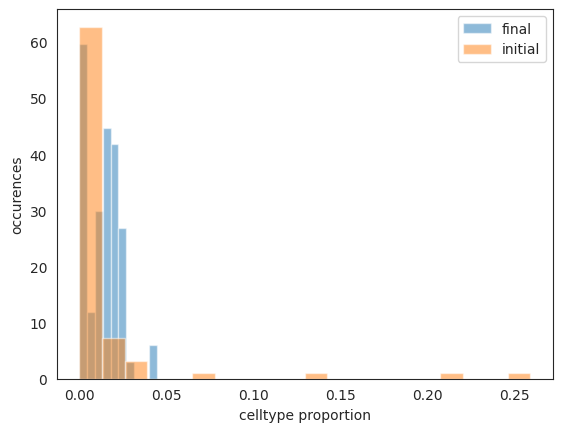

In [169]:
plt.hist(final_dist, bins=10, alpha=0.5, density=True)
plt.hist(initial_dist, bins=20, alpha=0.5, density=True)
plt.xlabel("celltype proportion")
plt.ylabel("occurences")
plt.legend(["final", "initial"])

In [170]:
cell_type_distribution.sort_values("Fraction", ascending=False)

,Cell Type,Fraction
48,pronephric podocyte,0.044715
2,fin bud mesoderm (pectoral),0.040448
30,odontoblast,0.027737
5,differentiating neuron (hindbrain),0.025938
15,neural progenitor (MHB),0.025693
...,...,...
23,red blood cell,0.000000
49,KA neuron,0.000000
47,xanthophore,0.000000
36,pronephros proximal tubule,0.000000


In [171]:
list_markov_steps = [0.01, 0.1, 1, 10, 100]
df_final_dist = pd.DataFrame()

for markov_step in list_markov_steps:
    P_t = expm(CG_trans_probs * markov_step)  # Matrix exponentiation at time t

    # Compute distribution at time t
    final_dist = np.dot(P_t, initial_dist)
     # Normalize the distribution to sum to 1
    final_dist /= np.sum(final_dist)
    df_final_dist[markov_step] = final_dist


# # Create a DataFrame for better visualization
# cell_type_distribution = pd.DataFrame({
#     'Cell Type': unique_cell_types,
#     'Fraction': final_dist
# })

In [172]:
df_final_dist.index = unique_cell_types

In [173]:
df_final_dist

,0.01,0.10,1.00,10.00,100.00
contains head vasculature?,0.001180,0.005644,0.012975,0.017944,0.018182
vascular smooth muscle,0.028702,0.022543,0.014564,0.018125,0.018182
fin bud mesoderm (pectoral),0.199667,0.137189,0.040448,0.018525,0.018182
posterior spinal cord progenitors,0.017037,0.019366,0.022570,0.018648,0.018182
pharynx,0.001660,0.009534,0.020191,0.018290,0.018182
...,...,...,...,...,...
melanophore,0.000000,0.000000,0.000000,0.000000,0.000000
cranial muscle (late),0.000000,0.000000,0.000000,0.000000,0.000000
jaw chondrocyte,0.000000,0.000000,0.000000,0.000000,0.000000
neuron (dopaminergic),0.000000,0.000000,0.000000,0.000000,0.000000


In [174]:
np.sum(df_final_dist, axis=0)

0.01      1.0
0.10      1.0
1.00      1.0
10.00     1.0
100.00    1.0
dtype: float64

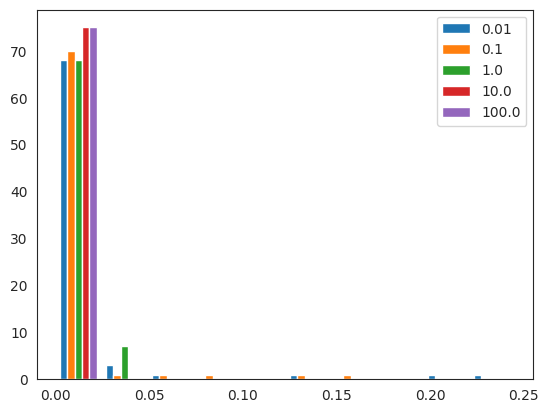

In [175]:
plt.hist(df_final_dist)
plt.legend(df_final_dist.columns)

### Computing the cost function and minimize it

In [8]:
# define the cost function...
def cost_function(t, initial_dist, next_dist, CG_trans_probs):
    P_t = expm(CG_trans_probs * t)  # Matrix exponentiation at time t
    final_dist = np.dot(P_t, initial_dist)
    final_dist /= np.sum(final_dist)  # Normalize the distribution
    J_t = np.sum((final_dist - next_dist) ** 2)
    return J_t

In [183]:
# # Example data (replace with your actual data)
# initial_dist = np.array([0.2, 0.5, 0.3])  # Example initial distribution
# second_dist = np.array([0.25, 0.45, 0.3])  # Example next distribution
# unique_cell_types = np.array(['type1', 'type2', 'type3'])
# CG_trans_probs = csr_matrix([[0.9, 0.1, 0.0],
#                              [0.1, 0.8, 0.1],
#                              [0.0, 0.1, 0.9]])  # Example sparse matrix

# Initial guess for t
t_initial_guess = np.array([1.0])  # Make sure it's an array

# Minimize the cost function
result = minimize(cost_function, t_initial_guess, args=(initial_dist, second_dist, CG_trans_probs), method='Nelder-Mead')

# Optimal t
optimal_t = result.x[0]

print(f'Optimal t: {optimal_t}')

Optimal t: 0.062304687499999165


In [188]:
# for a list of "t", compute the J(t)
list_markov_steps = np.linspace(0, 0.5, 51)

list_markov_steps

list_J_t = []

for step in list_markov_steps:
    J_t = cost_function(step, initial_dist, second_dist, CG_trans_probs)
    list_J_t.append(J_t)
    
list_J_t

[0.012399164176383579,
 0.008675353654119441,
 0.006067717748438861,
 0.004308156783874264,
 0.003197385940591259,
 0.002585550043492848,
 0.0023588054127970976,
 0.0024298804651529497,
 0.002731337305002519,
 0.003210696997562986,
 0.003826870014872513,
 0.004547513223042881,
 0.00534705287686644,
 0.006205191879439041,
 0.007105772915273696,
 0.008035905687528473,
 0.008985291949849572,
 0.009945699933175038,
 0.010910552505874202,
 0.011874602558804436,
 0.012833675747655036,
 0.013784465586580384,
 0.01472436947654016,
 0.015651356923098412,
 0.01656386320150318,
 0.01746070323953947,
 0.018341001638666893,
 0.019204135633825337,
 0.02004968846953666,
 0.02087741119418893,
 0.021687191282424162,
 0.02247902681476267,
 0.023253005194546855,
 0.024009285580490366,
 0.024748084370359334,
 0.025469663196580533,
 0.026174318994774168,
 0.026862375786665907,
 0.02753417788367531,
 0.028190084269916652,
 0.02883046396589854,
 0.02945569220884504,
 0.03006614731384146,
 0.03066220810316431

Text(0, 0.5, 'J(t) - cost function')

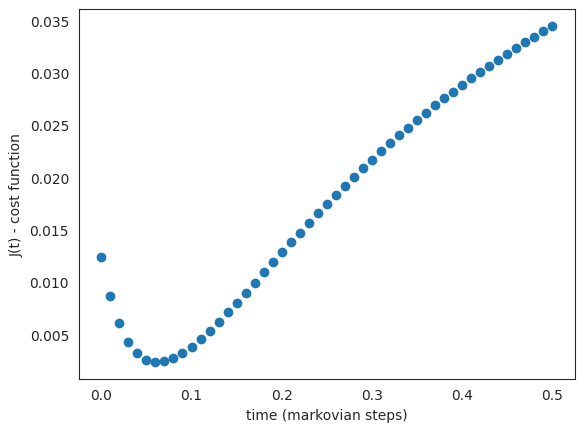

In [190]:
plt.scatter(list_markov_steps, list_J_t)
plt.xlabel("time (markovian steps)")
plt.ylabel("J(t) - cost function")

Text(0, 0.5, 'J(t) - cost function')

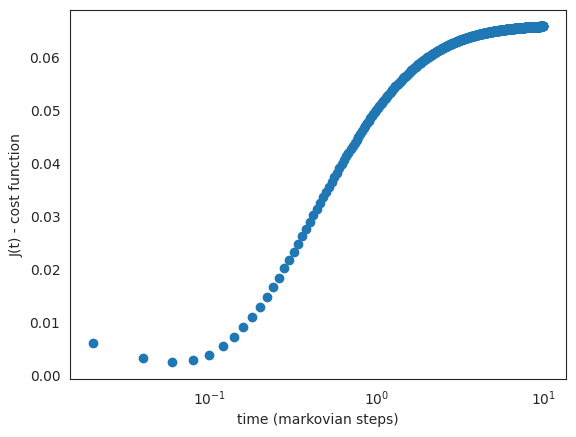

In [194]:
# for a list of "t", compute the J(t)
list_markov_steps = np.linspace(0, 10, 501)

# define an empty list to save the J(t)
list_J_t = []

for step in list_markov_steps:
    J_t = cost_function(step, initial_dist, second_dist, CG_trans_probs)
    list_J_t.append(J_t)
    
plt.scatter(list_markov_steps, list_J_t)
plt.xscale("log")
plt.xlabel("time (markovian steps)")
plt.ylabel("J(t) - cost function")

In [86]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.990034897262127e-30
             x: [-8.882e-16]
           nit: 18
          nfev: 36
 final_simplex: (array([[-8.882e-16],
                       [ 9.766e-05]]), array([ 3.990e-30,  4.577e-08]))

# Expanding this to all timepoints (05/23/2024)

-

In [11]:
# A collection of functions/modules
# Step 1. Extract the transition probabilities from the Oracle object
def compute_trans_probs(oracle, goi):
    """
    compute the transition probabilities from the Oracle object for given genes of interest (goi).
    
    Parameters:
        oracle: Oracle object containing the data.
        goi: Single gene (str) or list of genes (list of str) of interest.
    
    Returns:
        trans_probs: cell-cell transition probabilities matrix.
    """
#     # extract the adata from the oracle object
#     adata = oracle.adata

    # compute the transition probabilities for the given gene(s) of interest (goi)
    if not goi:
        perturb_condition = {}
    elif isinstance(goi, str):
        perturb_condition = {goi: 0.0}
    elif isinstance(goi, list):
        perturb_condition = {gene: 0.0 for gene in goi}
    else:
        raise ValueError("goi must be a string or a list of strings")
    # # extract the adata from the oracle object
    # adata = oracle.adata
    # adata

    # # compute the transition probabilities for a given gene (goi)
    # if goi=="":
    #     perturb_condition = {}
    # elif goi:
    #     perturb_condition = {goi: 0.0}
    
    # Enter perturbation conditions to simulate signal propagation after the perturbation.
    oracle.simulate_shift(perturb_condition=perturb_condition,
                        n_propagation=3)

    # estimate the cell-cell transition probability
    oracle.estimate_transition_prob(n_neighbors=200,
                                    knn_random=True,
                                    sampled_fraction=1)

    # Calculate embedding
    oracle.calculate_embedding_shift(sigma_corr=0.05)

    trans_probs = get_transition_matrix(oracle)

    return trans_probs


# Extract the transition probabilities
def get_transition_matrix(oracle):
    matrix = oracle.transition_prob.copy()
    dense_array = np.array(matrix, dtype=np.float32)
    trans_probs = dense_array
    # Convert dense array to a sparse matrix
    # sparse_matrix = csr_matrix(dense_array)
    #     adata.uns['transition_matrix'] = sparse_matrix
    return trans_probs

# Step 2. coarse-graining the cell-cell transition probabilities (macrostates/celltype level)
def coarse_graining_trans_probs(adata_master, trans_probs, data_key="TDR126", 
                                annotatio_key="scANVI_zscape"):

    # define the list of celltypes
    unique_cell_types = adata_master.obs[annotation_key].unique()

    # subset the adata_master into the subset for the given timepoint
    adata_sub = adata_master[adata_master.obs["dataset"]==data_key].copy()
    
    # Map each cell to its corresponding index
    cell_types = adata_sub.obs[annotation_key]
    type_to_index = {ctype: idx for idx, ctype in enumerate(unique_cell_types)}

    # Create a vector of these indices
    indices = cell_types.map(type_to_index).values

    # Initialize a matrix to store coarse-grained transition probabilities
    CG_trans_probs = np.zeros((len(unique_cell_types), len(unique_cell_types)))

    # For each cell type pair, sum the probabilities from trans_prob
    for i, ctype1 in enumerate(unique_cell_types):
        for j, ctype2 in enumerate(unique_cell_types):
            # Create masks for the rows and columns corresponding to each cell type
            mask_i = (indices == i)
            mask_j = (indices == j)

            # Aggregate transitions for these cell types
            CG_trans_probs[i, j] = np.sum(trans_probs[mask_i, :][:, mask_j])
        
    # Normalize the rows of CG_trans_probs to sum to 1
    row_sums = CG_trans_probs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Set zero sums to 1 to avoid division by zero
    CG_trans_probs = CG_trans_probs / row_sums
            
    return CG_trans_probs

# Function to compute initial distribution for a given timepoint or subset
def compute_celltype_dist(adata_sub, unique_cell_types, annotation_key):
    # Extract cell type information from the subset
    cell_types = adata_sub.obs[annotation_key]

    # Count the frequency of each cell type in the subset
    celltype_counts = cell_types.value_counts(normalize=True)

    # Convert counts to a sorted numpy array that matches the order of unique_cell_types
    celltype_dist = np.array([celltype_counts.get(ctype, 0) for ctype in unique_cell_types])

    return celltype_dist

# define the cost function
def cost_function(t, initial_dist, next_dist, CG_trans_probs):
    P_t = expm(CG_trans_probs * t)  # Matrix exponentiation at time t
    final_dist = np.dot(P_t, initial_dist)
    final_dist /= np.sum(final_dist)  # Normalize the distribution
    J_t = np.sum((final_dist - next_dist) ** 2)
    return J_t

# define the optimization function
def optimize_delta_time(initial_dist, next_dist, CG_trans_probs):
    # Initial guess for t
    t_initial_guess = np.array([1.0])  # Make sure it's an array
    
    # Define bounds to ensure t is non-negative
    bounds = [(0.001, None)]  # (0, None) means 0 <= t < infinity

    # Minimize the cost function
    result = minimize(cost_function, t_initial_guess, args=(initial_dist, next_dist, 
                                                            CG_trans_probs), method="Powell", bounds=bounds)#method='Nelder-Mead')
    
    # Optimal t
    optimal_t = result.x[0]
    print(f'Optimal t: {optimal_t}')

    return optimal_t

# define the function to simulate the celltype frequency
def simulated_celltype_dist(start_dist, CG_trans_probs, delta_time):
    P_t = expm(CG_trans_probs * delta_time)  # Matrix exponentiation at time t
    next_dist = np.dot(P_t, start_dist)
    next_dist /= np.sum(final_dist)  # Normalize the distribution
    
    return next_dist

In [197]:
adata_master.obs.dataset.unique()

['TDR118', 'TDR119', 'TDR124', 'TDR125', 'TDR126', 'TDR127', 'TDR128']
Categories (7, object): ['TDR118', 'TDR119', 'TDR124', 'TDR125', 'TDR126', 'TDR127', 'TDR128']

In [198]:
list_test = [5,4,3,2,1]

for index, test in enumerate(list_test):
    print(index, test)

0 5
1 4
2 3
3 2
4 1


In [12]:
# for a list of adata objects ("datasets"), compute the (1) celltype_dist, (2) trans.probs, and use the previous two to compute the (3) delta_T between the timepoints
list_datasets = ["TDR126","TDR127","TDR128","TDR119","TDR125"]#,"TDR124"]
list_data_ids = ["TDR126","TDR127","TDR128","TDR119reseq","TDR125reseq"]#,"TDR124reseq"]
list_timepoints = ["0somites","5somites","10somites","15somites","20somites"]#,"30somites"]


oracle_main_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/"

dict_CG_trans_probs = {}
dict_celltype_dist = {}

for index, dataset in enumerate(list_datasets):
    
    # data_id
    data_id = list_data_ids[index]
    
    # import the oracle object
    oracle = co.load_hdf5(oracle_main_path + f"{data_id}/10_{data_id}_pseudotime.celloracle.oracle")
    
    # compute the transition probability (WT)
    trans_probs = compute_trans_probs(oracle, "")
    
    # coarse-graining the trans_probs
    CG_trans_probs = coarse_graining_trans_probs(adata_master, trans_probs=trans_probs, 
                                                 data_key=dataset, annotatio_key="scANVI_zscape", )
    
    # subset the adata
    adata_sub = adata_master[adata_master.obs.dataset==dataset]
    
    # define the list of celltypes
    unique_cell_types = adata_master.obs[annotation_key].unique()
    
    # compute the celltype_dist
    celltype_dist =  compute_celltype_dist(adata_sub, unique_cell_types, annotation_key="scANVI_zscape")
    
    # save into the dictionar
    dict_CG_trans_probs[dataset] = CG_trans_probs
    dict_celltype_dist[dataset] = celltype_dist


In [15]:
# since TDR124reseq (30somites) were not computed for the Oracle object, so we'll just compute the celltype_dist
dataset = "TDR124"

# subset the adata
adata_sub = adata_master[adata_master.obs.dataset==dataset]

# define the list of celltypes
unique_cell_types = adata_master.obs[annotation_key].unique()

# compute the celltype_dist
celltype_dist =  compute_celltype_dist(adata_sub, unique_cell_types, annotation_key="scANVI_zscape")

# save into the dictionary
# dict_CG_trans_probs[dataset] = CG_trans_probs
# dict_celltype_dist[dataset] = celltype_dist



In [307]:
celltype_dist

array([1.51285930e-04, 1.01361573e-02, 3.02571861e-04, 3.02571861e-04,
       0.00000000e+00, 6.05143722e-04, 4.53857791e-04, 0.00000000e+00,
       3.17700454e-03, 2.54160363e-02, 1.51285930e-04, 0.00000000e+00,
       0.00000000e+00, 1.51285930e-04, 3.02571861e-04, 4.23600605e-03,
       7.26172466e-03, 4.68986384e-03, 7.71558245e-03, 7.56429652e-04,
       0.00000000e+00, 2.26928896e-03, 6.50529501e-03, 3.91830560e-02,
       0.00000000e+00, 7.77155825e-01, 0.00000000e+00, 1.51285930e-03,
       0.00000000e+00, 7.71558245e-03, 0.00000000e+00, 2.57186082e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51285930e-04,
       1.51285930e-04, 2.87443268e-03, 0.00000000e+00, 0.00000000e+00,
       1.22541604e-02, 2.57186082e-03, 0.00000000e+00, 5.74886536e-03,
       9.07715582e-04, 1.05900151e-03, 6.50529501e-03, 9.07715582e-04,
       0.00000000e+00, 8.62329803e-03, 6.05143722e-04, 1.51285930e-04,
       0.00000000e+00, 1.66414523e-03, 0.00000000e+00, 1.51285930e-04,
      

In [269]:
# sinceTDR126 (0somites) were not computed for the Oracle object, so we'll just compute the celltype_dist
dataset = "TDR126"

# subset the adata
adata_sub = adata_master[adata_master.obs.dataset==dataset]

# define the list of celltypes
unique_cell_types = adata_master.obs[annotation_key].unique()

# compute the celltype_dist
celltype_dist =  compute_celltype_dist(adata_sub, unique_cell_types, annotation_key="scANVI_zscape")

# save into the dictionar
# dict_CG_trans_probs[dataset] = CG_trans_probs
dict_celltype_dist[dataset] = celltype_dist



In [16]:
dict_celltype_dist

{'TDR126': array([3.99042298e-04, 2.97951583e-02, 2.10627827e-01, 1.66267624e-02,
        2.66028199e-04, 2.85980314e-03, 5.32056398e-04, 9.84304336e-03,
        1.02420857e-02, 0.00000000e+00, 1.06411280e-03, 2.19473264e-03,
        1.56291567e-02, 5.98563448e-04, 0.00000000e+00, 7.24926842e-03,
        3.79090184e-03, 2.17478053e-02, 0.00000000e+00, 3.37190742e-02,
        2.26123969e-03, 2.06171854e-03, 0.00000000e+00, 0.00000000e+00,
        2.04841713e-02, 6.65070497e-04, 1.33014099e-04, 2.66028199e-04,
        1.31683958e-02, 6.65070497e-05, 1.38733706e-01, 5.71960628e-03,
        2.26123969e-03, 7.98084597e-04, 2.87975525e-02, 3.52487364e-03,
        0.00000000e+00, 1.72918329e-03, 6.38467678e-03, 6.45118383e-03,
        6.65070497e-05, 3.32535249e-04, 5.25405693e-03, 0.00000000e+00,
        6.65070497e-05, 7.31577547e-04, 6.38467678e-03, 0.00000000e+00,
        2.59377494e-01, 0.00000000e+00, 2.99281724e-03, 6.65070497e-05,
        4.58898643e-03, 2.66028199e-04, 4.65549348e-04

In [285]:
dict_celltype_dist

start_dist = dict_celltype_dist["TDR126"]
start_dist

array([3.99042298e-04, 2.97951583e-02, 2.10627827e-01, 1.66267624e-02,
       2.66028199e-04, 2.85980314e-03, 5.32056398e-04, 9.84304336e-03,
       1.02420857e-02, 0.00000000e+00, 1.06411280e-03, 2.19473264e-03,
       1.56291567e-02, 5.98563448e-04, 0.00000000e+00, 7.24926842e-03,
       3.79090184e-03, 2.17478053e-02, 0.00000000e+00, 3.37190742e-02,
       2.26123969e-03, 2.06171854e-03, 0.00000000e+00, 0.00000000e+00,
       2.04841713e-02, 6.65070497e-04, 1.33014099e-04, 2.66028199e-04,
       1.31683958e-02, 6.65070497e-05, 1.38733706e-01, 5.71960628e-03,
       2.26123969e-03, 7.98084597e-04, 2.87975525e-02, 3.52487364e-03,
       0.00000000e+00, 1.72918329e-03, 6.38467678e-03, 6.45118383e-03,
       6.65070497e-05, 3.32535249e-04, 5.25405693e-03, 0.00000000e+00,
       6.65070497e-05, 7.31577547e-04, 6.38467678e-03, 0.00000000e+00,
       2.59377494e-01, 0.00000000e+00, 2.99281724e-03, 6.65070497e-05,
       4.58898643e-03, 2.66028199e-04, 4.65549348e-04, 1.33014099e-04,
      

In [294]:
# compute the delta_time (markovian steps) between the timepoints
list_datasets = ['TDR126', 'TDR127', 'TDR128', 'TDR119', 'TDR125', "TDR124"]
list_delta_time = []

for index, dataset in enumerate(list_datasets[:-1]):
    # extract the start_dist, and next_dist
    next_dataset = list_datasets[index+1]
    
    start_dist = dict_celltype_dist[dataset]
    next_dist = dict_celltype_dist[next_dataset]
    
    # extract the CG_trans_probs
    CG_trans_probs = dict_CG_trans_probs[dataset]
    
    optimal_t = optimize_delta_time(start_dist, next_dist, CG_trans_probs)
    
    list_delta_time.append(optimal_t)
    

Optimal t: 0.062263407572533555
Optimal t: 0.4287554732049296
Optimal t: 0.0010000079818182398
Optimal t: 0.16987106862886803
Optimal t: 0.0010000079818182398


In [13]:
list_delta_time = [0.062263407572533555, 0.4287554732049296, 0.0010000079818182398, 0.16987106862886803, 0.0010000079818182398]
list_delta_time

[0.062263407572533555,
 0.4287554732049296,
 0.0010000079818182398,
 0.16987106862886803,
 0.0010000079818182398]

In [230]:
list_realtime = [10, 12, 14, 16, 19, 24]

# compute the list_delta_realtime
list_delta_realtime = [list_realtime[i] - list_realtime[i - 1] for i in range(1, len(list_realtime))]
list_delta_realtime # hours

[2, 2, 2, 3, 5]

Text(0, 0.5, 'delta T (markovian steps)')

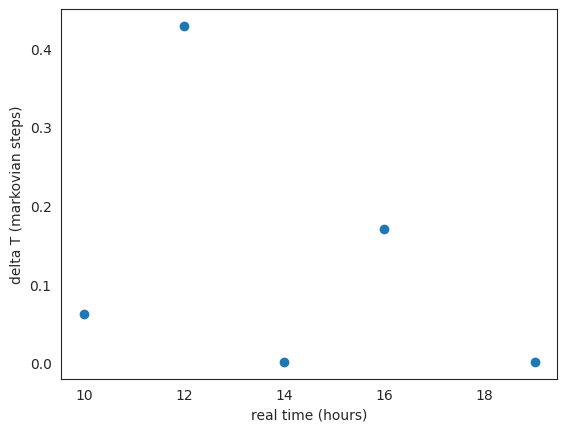

In [233]:
plt.scatter(list_realtime[:-1], list_delta_time)
plt.xlabel("real time (hours)")
plt.ylabel("delta T (markovian steps)")

Text(0, 0.5, 'delta T (markovian steps)')

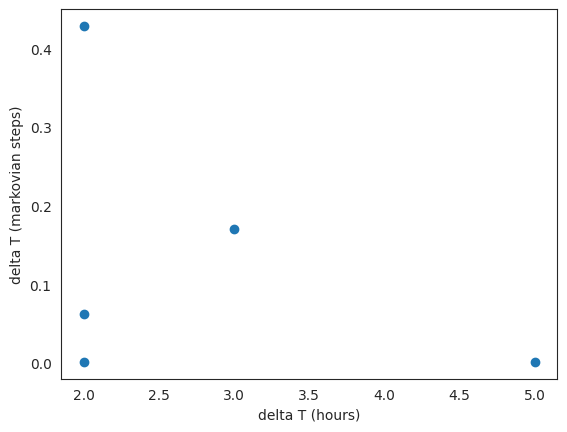

In [231]:
plt.scatter(list_delta_realtime, list_delta_time)
plt.xlabel("delta T (hours)")
plt.ylabel("delta T (markovian steps)")

Text(0, 0.5, 'J(t) - cost function')

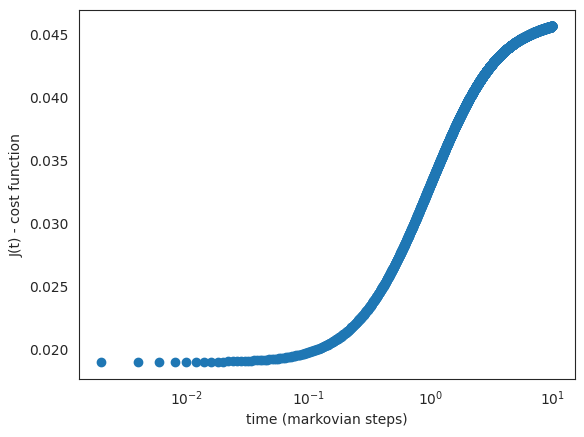

In [224]:
# for a list of "t", compute the J(t)
list_markov_steps = np.linspace(0, 10, 5001)

# define an empty list to save the J(t)
list_J_t = []

# define the start_dist and next_dist
start_dist = dict_celltype_dist["TDR128"]
next_dist = dict_celltype_dist["TDR119"]

CG_trans_probs = dict_CG_trans_probs["TDR128"]

for step in list_markov_steps:
    J_t = cost_function(step, start_dist, next_dist, CG_trans_probs)
    list_J_t.append(J_t)
    
plt.scatter(list_markov_steps, list_J_t)
plt.xscale("log")
plt.xlabel("time (markovian steps)")
plt.ylabel("J(t) - cost function")

## generating virtual embryos - 

In [17]:
list_delta_time

[0.062263407572533555,
 0.4287554732049296,
 0.0010000079818182398,
 0.16987106862886803,
 0.0010000079818182398]

In [18]:
len(list_datasets)

5

In [272]:
list_data_ids

['TDR126', 'TDR127', 'TDR128', 'TDR119reseq', 'TDR125reseq']

In [30]:
# for a list of adata objects ("datasets"), compute the (1) celltype_dist, (2) trans.probs, and use the previous two to compute the (3) delta_T between the timepoints
list_datasets = ["TDR126","TDR127","TDR128","TDR119","TDR125"]
list_data_ids = ["TDR126","TDR127","TDR128","TDR119reseq","TDR125reseq"]
list_timepoints = ["0somites","5somites","10somites","15somites","20somites"]

list_delta_time


oracle_main_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/"

start_dist = dict_celltype_dist["TDR126"]

# define the function to simulate the celltype frequency
def simulated_celltype_dist(start_dist, CG_trans_probs, delta_time):
    P_t = expm(CG_trans_probs * delta_time)  # Matrix exponentiation at time t
    next_dist = np.dot(P_t, start_dist)
    next_dist /= np.sum(next_dist)  # Normalize the distribution
    
    return next_dist

def simulate_virtual_embryo(list_datasets, adata_master, list_KO_genes, start_dist):
    
#     dict_CG_trans_probs = {}
    dict_celltype_dist = {}
    index=0
    
    while index<len(list_datasets):
#     for index, dataset in enumerate(list_datasets):
        
        # data_id
        data_id = list_data_ids[index]
        print(data_id)
        # dataset
        dataset = list_datasets[index]
        print(dataset)

    
        # take the start_dist for the simulation (previous timepoint)
        if index==0:
            start_dist = start_dist
        else:
            previous_dataset = list_datasets[index-1]
            start_dist = dict_celltype_dist[previous_dataset]

        # import the oracle object
        print("Oracle object being imported...")
        oracle = co.load_hdf5(oracle_main_path + f"{data_id}/10_{data_id}_pseudotime.celloracle.oracle")
        
#         print(oracle.adata)

        # compute the transition probability (WT)
        print("in silico KO simulation...")
        trans_probs = compute_trans_probs(oracle, list_KO_genes)

        # coarse-graining the trans_probs
#         print(dataset)
        CG_trans_probs = coarse_graining_trans_probs(adata_master, data_key=dataset, 
                                    annotatio_key="scANVI_zscape", trans_probs=trans_probs)

        # simulate the cell transitions
        delta_time = list_delta_time[index]
        next_dist = simulated_celltype_dist(start_dist, CG_trans_probs, delta_time)
        
        dict_celltype_dist[dataset] = next_dist
        
        index = index+1
        
    # take the last timepoint's celltype_dist as the final_dist of celltypes
    final_dist = dict_celltype_dist["TDR125"]
    
    print("KO complted: ", list_KO_genes)
    
#     return final_dist
    return final_dist


In [31]:
final_dist = simulate_virtual_embryo(list_datasets, adata_master, "myog", start_dist)
final_dist

TDR126
TDR126
Oracle object being imported...
in silico KO simulation...
TDR127
TDR127
Oracle object being imported...
in silico KO simulation...
TDR128
TDR128
Oracle object being imported...
in silico KO simulation...
TDR119reseq
TDR119
Oracle object being imported...
in silico KO simulation...
TDR125reseq
TDR125
Oracle object being imported...
in silico KO simulation...
KO complted:  myog


array([1.26375966e-02, 1.69127908e-02, 6.81963297e-02, 2.08672238e-02,
       1.70812660e-02, 2.02107671e-02, 1.53924396e-02, 1.00626557e-02,
       1.65065785e-02, 2.05649330e-03, 1.12018081e-02, 9.09012660e-03,
       1.43938747e-02, 1.58458317e-02, 1.29898098e-03, 1.88831292e-02,
       1.02794387e-02, 1.89086089e-02, 2.17803684e-03, 1.99515192e-02,
       1.70019648e-02, 1.36716555e-02, 1.63564193e-02, 1.14812978e-03,
       1.75438722e-02, 2.00108163e-02, 9.89979547e-03, 8.82404493e-03,
       1.96395276e-02, 9.44909467e-03, 4.00344693e-02, 1.29393627e-02,
       1.40769772e-02, 2.29671180e-02, 1.39840570e-02, 1.72857103e-02,
       1.09372161e-02, 8.67126247e-03, 1.53504276e-02, 1.41043546e-02,
       1.15826649e-02, 1.23434976e-02, 1.81087500e-02, 2.17454098e-03,
       1.02960001e-02, 1.30598358e-02, 9.69832503e-03, 2.42814489e-03,
       6.82897746e-02, 2.11805647e-03, 2.03117960e-02, 1.36034681e-02,
       1.29595792e-02, 1.45495344e-02, 1.18285314e-02, 1.37405656e-02,
      

In [28]:
dict_celltype_dist["TDR125"]

array([9.72616222e-03, 2.87153361e-02, 2.19996526e-02, 4.08730388e-02,
       5.21044405e-04, 1.92786430e-01, 2.21154403e-02, 2.06680947e-02,
       2.87153361e-02, 2.47206623e-02, 1.05366757e-02, 2.43154055e-03,
       5.44201934e-03, 7.29462166e-03, 4.26677474e-02, 6.03832571e-02,
       1.18103398e-02, 5.73148845e-02, 3.41573554e-03, 3.80362415e-02,
       2.89469114e-04, 3.01047878e-03, 3.28257975e-02, 2.43154055e-02,
       2.95258496e-03, 1.05598333e-01, 6.07885139e-03, 1.08261449e-02,
       5.21044405e-04, 2.41996179e-02, 0.00000000e+00, 1.58629074e-02,
       2.83100793e-02, 5.21044405e-04, 6.36832050e-04, 4.97886875e-03,
       1.27366410e-03, 3.53152319e-03, 3.53152319e-03, 2.89469114e-03,
       6.54200197e-03, 6.07885139e-03, 3.47362936e-04, 3.41573554e-03,
       2.14207144e-03, 5.15255022e-03, 8.97354252e-03, 6.25253285e-03,
       2.31575291e-04, 2.02628380e-03, 1.07103572e-02, 5.09465640e-03,
       3.41573554e-03, 2.83679731e-03, 1.33155792e-03, 6.54200197e-03,
      

In [21]:
list_data_ids

['TDR126', 'TDR127', 'TDR128', 'TDR119reseq', 'TDR125reseq']

In [22]:
# Initialize the intersection set with the TFs from the first dataset
print("Oracle object being imported...")
initial_oracle = co.load_hdf5(oracle_main_path + f"{list_data_ids[0]}/10_{list_data_ids[0]}_pseudotime.celloracle.oracle")
tf_intersection = set(initial_oracle.active_regulatory_genes)

# Iterate over all datasets to find the intersection of TFs
for index, dataset in enumerate(list_datasets):
    data_id = list_data_ids[index]
    
    print(f"Processing dataset: {dataset} (data_id: {data_id})")
    
    # Import the oracle object
    oracle_path = oracle_main_path + f"{data_id}/10_{data_id}_pseudotime.celloracle.oracle"
    print(f"Oracle object being imported from {oracle_path}...")
    oracle = co.load_hdf5(oracle_path)
    
    # Get the list of active regulatory genes (TFs)
    list_TFs = oracle.active_regulatory_genes
    print(f"Number of TFs in {dataset}: {len(list_TFs)}")
    
    # Update the intersection set
    tf_intersection.intersection_update(list_TFs)
    
    print(f"Current intersection size: {len(tf_intersection)}")

print(f"Final intersection of TFs: {len(tf_intersection)}")
print(tf_intersection)

# Optional: Convert the intersection set to a list if needed
list_TF_intersection = list(tf_intersection)

Oracle object being imported...
Processing dataset: TDR126 (data_id: TDR126)
Oracle object being imported from /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/TDR126/10_TDR126_pseudotime.celloracle.oracle...
Number of TFs in TDR126: 326
Current intersection size: 326
Processing dataset: TDR127 (data_id: TDR127)
Oracle object being imported from /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/TDR127/10_TDR127_pseudotime.celloracle.oracle...
Number of TFs in TDR127: 309
Current intersection size: 262
Processing dataset: TDR128 (data_id: TDR128)
Oracle object being imported from /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/TDR128/10_TDR128_pseudotime.celloracle.oracle...
Number of TFs in TDR128: 334
Current intersection size: 236
Processing dataset: TDR119 (data_id: TDR119reseq)
Oracle object being imported from /h

In [ ]:
# Run this virtual embryo for all TFs within the GRNs
list_TF_intersection

# define a dataframe to save the results
df_virtual_embryo = pd.DataFrame()

for gene in list_TF_intersection:
    print(gene)
    try:
        final_dist = simulate_virtual_embryo(list_datasets, adata_master, gene, start_dist)
        
        # Create a DataFrame row for the current gene's final distribution
        df_gene_dist = pd.DataFrame([final_dist], columns=unique_cell_types, index=[gene])
        # Append the current gene's distribution to the main DataFrame
        df_virtual_embryo = pd.concat([df_virtual_embryo, df_gene_dist])
        print(gene, " KO is completed")
        
    except:
        print(gene, " is not present in the GRNs/Oracle")
        

df_virtual_embryo.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/03_celloracle_celltype_GRNs/virtual_embryo_DPT_pseudotime_24hpf.csv")


nfatc3a
TDR126
TDR126
Oracle object being imported...
in silico KO simulation...
TDR127
TDR127
Oracle object being imported...
in silico KO simulation...
TDR128
TDR128
Oracle object being imported...
in silico KO simulation...
TDR119reseq
TDR119
Oracle object being imported...
in silico KO simulation...
TDR125reseq
TDR125
Oracle object being imported...
in silico KO simulation...
KO complted:  nfatc3a
nfatc3a  KO is completed
isl1
TDR126
TDR126
Oracle object being imported...
in silico KO simulation...
TDR127
TDR127
Oracle object being imported...
in silico KO simulation...
TDR128
TDR128
Oracle object being imported...
in silico KO simulation...
TDR119reseq
TDR119
Oracle object being imported...
in silico KO simulation...
TDR125reseq
TDR125
Oracle object being imported...
in silico KO simulation...
KO complted:  isl1
isl1  KO is completed
tfap2b
TDR126
TDR126
Oracle object being imported...
in silico KO simulation...
TDR127
TDR127
Oracle object being imported...
in silico KO simulation

In [311]:
dict_celltype_dist["TDR125"]

array([9.72616222e-03, 2.87153361e-02, 2.19996526e-02, 4.08730388e-02,
       5.21044405e-04, 1.92786430e-01, 2.21154403e-02, 2.06680947e-02,
       2.87153361e-02, 2.47206623e-02, 1.05366757e-02, 2.43154055e-03,
       5.44201934e-03, 7.29462166e-03, 4.26677474e-02, 6.03832571e-02,
       1.18103398e-02, 5.73148845e-02, 3.41573554e-03, 3.80362415e-02,
       2.89469114e-04, 3.01047878e-03, 3.28257975e-02, 2.43154055e-02,
       2.95258496e-03, 1.05598333e-01, 6.07885139e-03, 1.08261449e-02,
       5.21044405e-04, 2.41996179e-02, 0.00000000e+00, 1.58629074e-02,
       2.83100793e-02, 5.21044405e-04, 6.36832050e-04, 4.97886875e-03,
       1.27366410e-03, 3.53152319e-03, 3.53152319e-03, 2.89469114e-03,
       6.54200197e-03, 6.07885139e-03, 3.47362936e-04, 3.41573554e-03,
       2.14207144e-03, 5.15255022e-03, 8.97354252e-03, 6.25253285e-03,
       2.31575291e-04, 2.02628380e-03, 1.07103572e-02, 5.09465640e-03,
       3.41573554e-03, 2.83679731e-03, 1.33155792e-03, 6.54200197e-03,
      

In [321]:
np.sum(celltype_dist)

1.0

In [320]:
np.sum(dict_celltype_dist["TDR125"])

1.0

In [325]:
list_TFs = oracle.active_regulatory_genes
len(list_TFs)

265

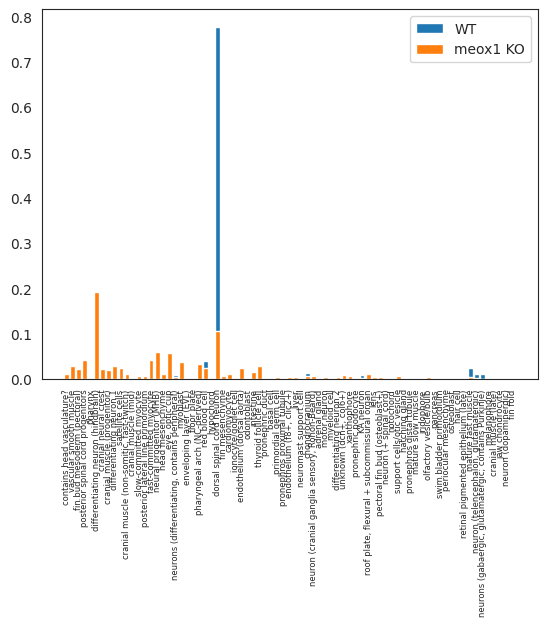

In [329]:
# fig, ax = plt.figure(figsize=(10, 5))
plt.bar(x = unique_cell_types, height = celltype_dist)
plt.bar(x = unique_cell_types, height = dict_celltype_dist["TDR125"])
plt.xticks(rotation=90, fontsize=6)
plt.legend(["WT","meox1 KO"])
plt.show()

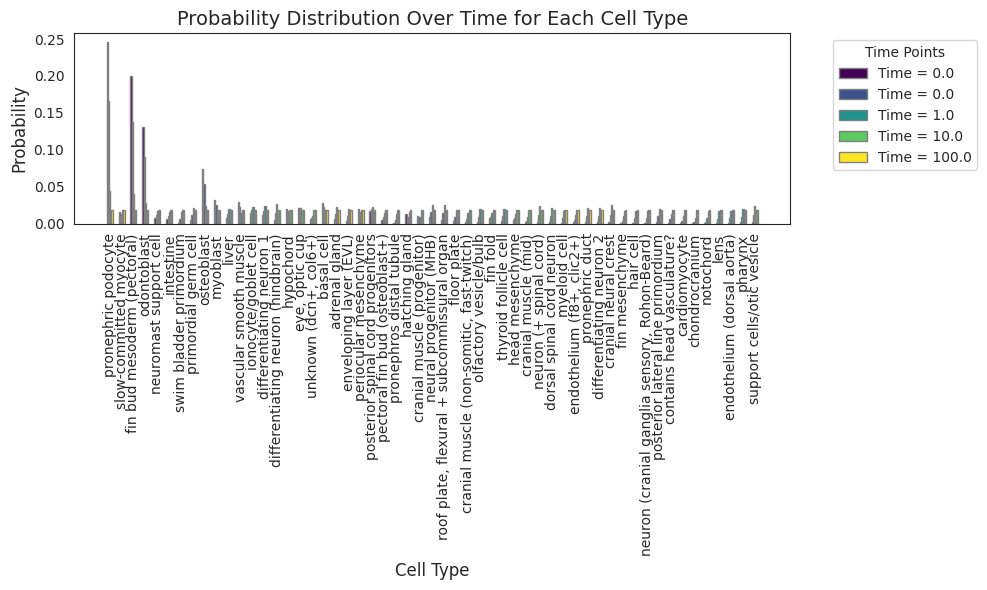

In [82]:
# Assume df_final_dist is already filled with your data, where each column represents a timepoint
# and the index corresponds to 'unique_cell_types'.
cell_type_labels = list(unique_cell_types)
time_points = list_markov_steps

# Setting up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Number of cell types
n_cell_types = len(cell_type_labels)
# Number of different time points
n_time_points = len(time_points)

# Width of each bar
bar_width = 0.1

# Positions of the bars on the x-axis
r = np.arange(n_cell_types)

# Get a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_time_points))

# Create bars for each time point
for idx, (markov_step, color) in enumerate(zip(time_points, colors)):
    ax.bar(r + idx * bar_width, df_final_dist[markov_step], width=bar_width, color=color, edgecolor='gray', label=f'Time = {np.floor(markov_step)}')

# General layout
ax.set_xlabel('Cell Type', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Probability Distribution Over Time for Each Cell Type', fontsize=14)
ax.set_xticks(r + bar_width * (n_time_points - 1) / 2)
ax.set_xticklabels(cell_type_labels)
ax.legend(title="Time Points", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of plot

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [135]:
# Define a function to compute the markovian simulation
def compute_markovian_sim(adata, annotation, trans_probs, list_n_steps=[0, 0.1, 1, 10]):
    """
    Compute Markovian simulation of cell fates using cell-cell transition probabilities
    """
    # Extract cell type information from adata.obs
    cell_types = adata.obs[annotation]

    # Define the unique cell types
    unique_cell_types = cell_types.unique()

    # Count the frequency of each cell type
    celltype_counts = cell_types.value_counts(normalize=True)
    celltype_counts

    # Convert counts to a sorted numpy array that matches the order of unique_cell_types
    initial_dist = np.array([celltype_counts.get(ctype, 0) for ctype in unique_cell_types])
    initial_dist

    # Coarse-graining the cell-cell transition probabilities
    # Map each cell to its corresponding index
    unique_cell_types = np.unique(cell_types)
    type_to_index = {ctype: idx for idx, ctype in enumerate(unique_cell_types)}

    # Create a vector of these indices
    indices = cell_types.map(type_to_index).values

    # Initialize a matrix to store coarse-grained transition probabilities
    CG_trans_probs = np.zeros((len(unique_cell_types), len(unique_cell_types)))

    # convert the pandas dataframe into numpy arrays
    trans_prob_matrix = trans_probs.values  # Convert DataFrame to NumPy array for faster operations


    # For each cell type pair, sum the probabilities from trans_prob
    for i, ctype1 in enumerate(unique_cell_types):
        for j, ctype2 in enumerate(unique_cell_types):
            # Create masks for the rows and columns corresponding to each cell type
            mask_i = (indices == i)
            mask_j = (indices == j)

            # Aggregate transitions for these cell types
            CG_trans_probs[i, j] = np.sum(trans_prob_matrix[mask_i, :][:, mask_j])
            
    # Normalize the rows of CG_trans_probs to sum to 1
    CG_trans_probs = CG_trans_probs / CG_trans_probs.sum(axis=1, keepdims=True)

    list_markov_steps = [0.01, 0.1, 1, 10, 100]
    df_final_dist = pd.DataFrame()

    for markov_step in list_n_steps:
        P_t = expm(CG_trans_probs * markov_step)  # Matrix exponentiation at time t

        # Compute distribution at time t
        final_dist = np.dot(P_t, initial_dist)
        # Normalize the distribution to sum to 1
        final_dist /= np.sum(final_dist)
        df_final_dist[markov_step] = final_dist

    # Convert CG_trans_probs to a DataFrame for better readability
    CG_trans_probs_df = pd.DataFrame(CG_trans_probs, index=unique_cell_types, columns=unique_cell_types)

    return df_final_dist, CG_trans_probs_df

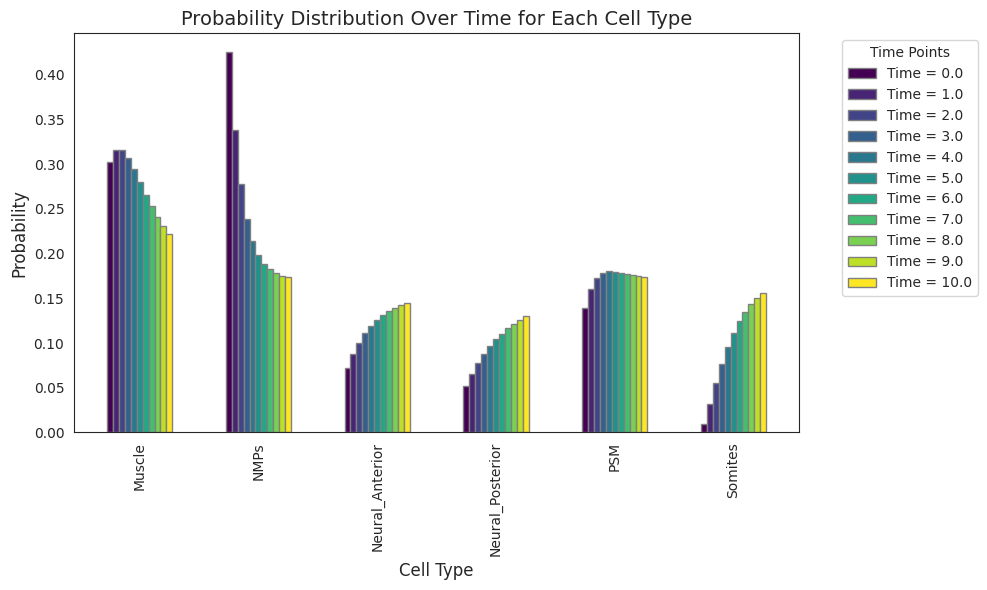

In [167]:
# Assume df_final_dist is already filled with your data, where each column represents a timepoint
# and the index corresponds to 'unique_cell_types'.
unique_cell_types = adata.obs.manual_annotation.unique()
cell_type_labels = df_final_dist.index
time_points = df_final_dist.columns

# Setting up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Number of cell types
n_cell_types = len(cell_type_labels)
# Number of different time points
n_time_points = len(time_points)

# Width of each bar
bar_width = 0.05

# Positions of the bars on the x-axis
r = np.arange(n_cell_types)

# Get a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_time_points))

# Create bars for each time point
for idx, (markov_step, color) in enumerate(zip(time_points, colors)):
    ax.bar(r + idx * bar_width, df_final_dist[markov_step], width=bar_width, color=color, edgecolor='gray', label=f'Time = {np.floor(markov_step)}')

# General layout
ax.set_xlabel('Cell Type', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Probability Distribution Over Time for Each Cell Type', fontsize=14)
ax.set_xticks(r + bar_width * (n_time_points - 1) / 2)
ax.set_xticklabels(cell_type_labels)
ax.legend(title="Time Points", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of plot

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## simulate the KO cases

### KO for meox1

In [175]:
def generate_colorandum(oracle, annotation, cell_types):
    """
    Generate the colorandum for the cell types
    """
    # Generate "Set3" color palette
    set3_palette = sns.color_palette("Set3", n_colors=len(cell_types))

    # Suppose the light yellow is the 10th color in the palette (9th index, as indexing is 0-based)
    # and you want to replace it with teal color
    teal_color = (0.0, 0.5019607843137255, 0.5019607843137255)  # RGB for teal
    set3_palette[1] = teal_color  # Replace the light yellow with teal

    # Assign colors to cell types
    custom_palette = {cell_type: color for cell_type, color in zip(cell_types, set3_palette)}
    # Change the color for 'NMPs' to a dark blue
    custom_palette['NMPs'] = (0.12941176470588237, 0.4, 0.6745098039215687)  # Dark blue color

    # Get the order of categories as they appear in the dataset
    categories_in_order = oracle.adata.obs[annotation].cat.categories

    # Reorder your palette dictionary to match this order
    ordered_palette = {cat: custom_palette[cat] for cat in categories_in_order if cat in custom_palette}

    # Now assign this ordered palette back to the AnnData object
    annotation_color = annotation + "_color"
    oracle.adata.uns[annotation_color] = ordered_palette

    # Change the color palette in the Oracle object
    # Extract the cell type annotations from the AnnData object
    cell_types = oracle.adata.obs[annotation].values

    # Map each cell type to its corresponding color
    colors_for_cells = np.array([custom_palette[cell_type] for cell_type in cell_types])

    # Replace the colorandum in the oracle object
    oracle.colorandum = colors_for_cells

    return oracle

In [177]:
import seaborn as sns
cell_types = [
    'Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
    'Neural_Anterior', 'Neural_Crest', 'Differentiating_Neurons',
    'Adaxial_Cells', 'Muscle', 'Somites', 'Endoderm', 'Notochord',
    'NMPs'
]

oracle = generate_colorandum(oracle, "manual_annotation", cell_types)

In [197]:
def simulate_KO(oracle_object, gene):
    oracle = oracle_object
    goi = gene
    
    # simulate the shift in gene expression
    oracle.simulate_shift(perturb_condition={goi: 0.0},
                          n_propagation=3)

    # Get transition probability
    oracle.estimate_transition_prob(n_neighbors=200,
                                    knn_random=True, 
                                    sampled_fraction=1)

    # Calculate embedding 
    oracle.calculate_embedding_shift(sigma_corr=0.05)
    
    return oracle

In [198]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
goi = "meox1"
oracle = simulate_KO(oracle, goi)
